## Samples of Predictions


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras import models
import datasets_util as du
import target_formatter as tgf

In [2]:
full_catalog, _ = du.get_full_gz2()

# split to data used for modeling and data not used

model_catalog = full_catalog.iloc[:50000, :]
train_catalog, test_catalog = train_test_split(
    model_catalog, test_size=0.2, random_state=1
)

extra_catalog = full_catalog.iloc[50000:, :]

# need training data to reproduce target encoder
y_encoder = tgf.get_summary_encoder(train_catalog)

model = models.load_model("galaxy_classification_model.keras")

In [3]:
summary_names = [ft.lstrip("x0_") for ft in y_encoder.get_feature_names_out()]
display(summary_names)
# don't use "None" for finding instances later
summary_names.remove("None")

['barred_spiral',
 'edge_on_disk',
 'featured_without_bar_or_spiral',
 'smooth_cigar',
 'smooth_inbetween',
 'smooth_round',
 'unbarred_spiral',
 'None']

In [4]:
first_instances = pd.DataFrame(
    [
        extra_catalog[extra_catalog["summary"] == name][["file_loc", "summary"]].iloc[0]
        for name in summary_names
    ]
)
first_instances

,file_loc,summary
50008,Resources\gz2\images\587736\587736584969715772...,barred_spiral
50003,Resources\gz2\images\587742\587742611347996705...,edge_on_disk
50016,Resources\gz2\images\587736\587736809382609093...,featured_without_bar_or_spiral
50022,Resources\gz2\images\587733\587733079200104531...,smooth_cigar
50000,Resources\gz2\images\587735\587735346963677274...,smooth_inbetween
50001,Resources\gz2\images\588017\588017726543822929...,smooth_round
50002,Resources\gz2\images\587729\587729408085721579...,unbarred_spiral


In [5]:
# encode & build datasets like in training
y_predict = tgf.get_summary_enc(y_encoder, first_instances)
predict_ds = du.get_dataset(first_instances["file_loc"], y_predict, 224)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
predictions = model.predict(predict_ds, verbose=0)
display(predictions)

predicted_summary = y_encoder.inverse_transform(predictions)
predicted_summary

array([[1.3036084e-01, 6.5802069e-06, 6.7038245e-02, 3.5876412e-06,
        1.7066706e-02, 2.4420568e-03, 7.1257555e-01, 7.0506439e-02],
       [1.6281553e-01, 5.5026263e-02, 9.4218515e-02, 9.7473869e-03,
        4.4476152e-03, 5.3819892e-04, 3.7813291e-01, 2.9507354e-01],
       [1.0324964e-01, 7.5444807e-03, 8.3886825e-02, 2.1131963e-02,
        3.9724785e-01, 2.6181515e-02, 1.9056879e-01, 1.7018893e-01],
       [2.8147097e-06, 4.1714869e-02, 8.6505161e-06, 8.7483847e-01,
        1.4224954e-06, 1.4371171e-11, 3.2667167e-04, 8.3107151e-02],
       [4.9820981e-05, 3.0772513e-05, 7.3825329e-05, 8.5190739e-03,
        9.8142689e-01, 3.9705203e-04, 2.7218732e-04, 9.2304423e-03],
       [4.3487904e-07, 2.3448063e-09, 3.8412324e-07, 3.5986918e-09,
        4.0450406e-01, 5.9129059e-01, 1.1063703e-06, 4.2033913e-03],
       [5.0709084e-02, 1.7603117e-05, 4.1797131e-02, 7.5396383e-05,
        3.5574442e-01, 2.4682948e-02, 4.4196960e-01, 8.5003830e-02]],
      dtype=float32)

array([['unbarred_spiral'],
       ['unbarred_spiral'],
       ['smooth_inbetween'],
       ['smooth_cigar'],
       ['smooth_inbetween'],
       ['smooth_round'],
       ['unbarred_spiral']], dtype=object)

In [7]:
results_df = pd.DataFrame(
    {
        "file_loc": first_instances["file_loc"],
        "expected": first_instances["summary"],
        "predicted": predicted_summary.flatten(),
    }
)
results_df

,file_loc,expected,predicted
50008,Resources\gz2\images\587736\587736584969715772...,barred_spiral,unbarred_spiral
50003,Resources\gz2\images\587742\587742611347996705...,edge_on_disk,unbarred_spiral
50016,Resources\gz2\images\587736\587736809382609093...,featured_without_bar_or_spiral,smooth_inbetween
50022,Resources\gz2\images\587733\587733079200104531...,smooth_cigar,smooth_cigar
50000,Resources\gz2\images\587735\587735346963677274...,smooth_inbetween,smooth_inbetween
50001,Resources\gz2\images\588017\588017726543822929...,smooth_round,smooth_round
50002,Resources\gz2\images\587729\587729408085721579...,unbarred_spiral,unbarred_spiral


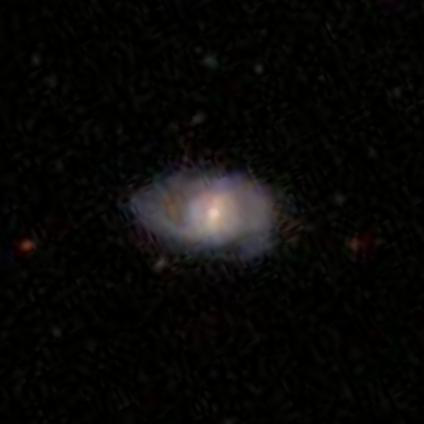

Expected: barred_spiral, predicted: unbarred_spiral


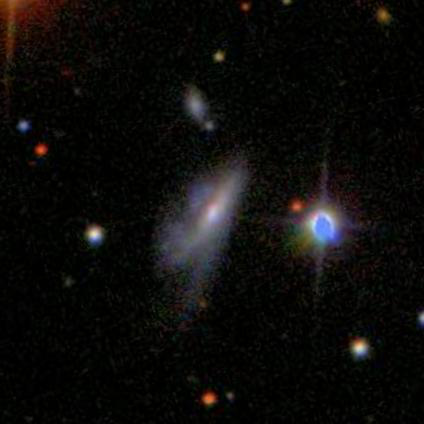

Expected: edge_on_disk, predicted: unbarred_spiral


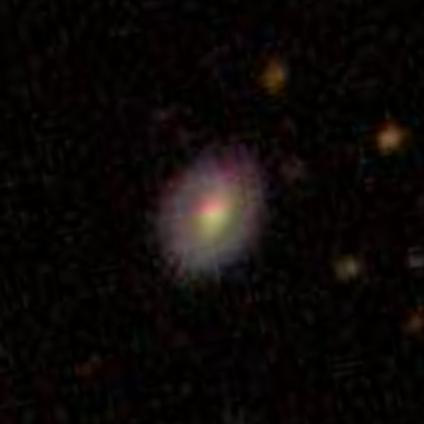

Expected: featured_without_bar_or_spiral, predicted: smooth_inbetween


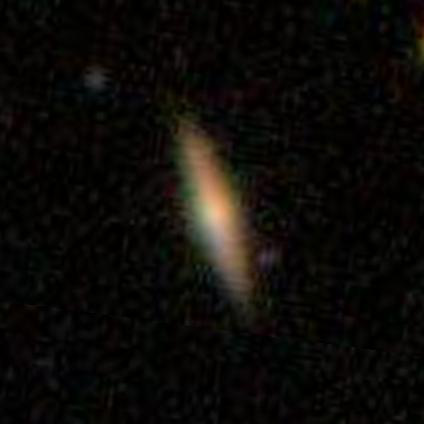

Expected: smooth_cigar, predicted: smooth_cigar


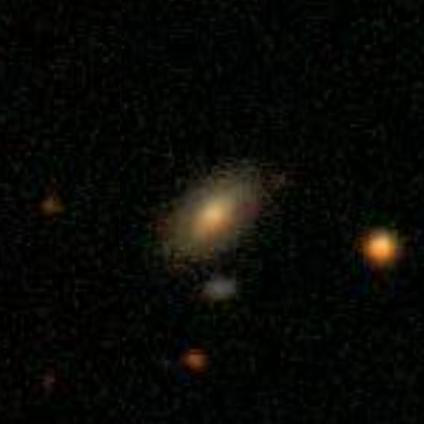

Expected: smooth_inbetween, predicted: smooth_inbetween


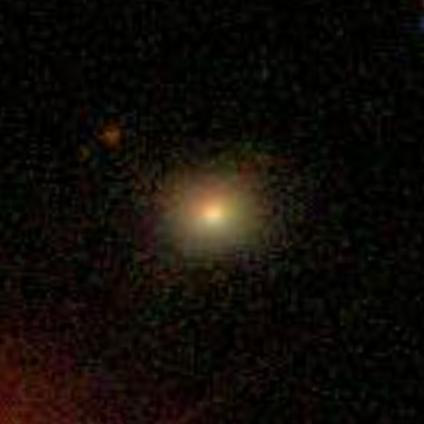

Expected: smooth_round, predicted: smooth_round


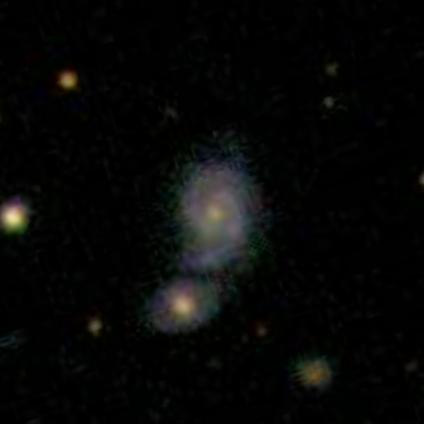

Expected: unbarred_spiral, predicted: unbarred_spiral


In [8]:
for _, row in results_df.iterrows():
    display(Image.open(row["file_loc"]))
    expected = row["expected"]
    predicted = row["predicted"]
    print(f"Expected: {expected}, predicted: {predicted}")